In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_palette("viridis")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.grid'] = True

In [29]:
# Load the external dataset
def load_data(filepath, name):
    df = pd.read_csv(filepath)
    print(f"{name} data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
    return df

external = load_data("../data/interim/cleaned_external_data.csv", "external")

external data loaded successfully with 2029 rows and 3 columns.


# Exploratory Data Analysis


## Data Summary


In [31]:
# Get the descriptive statistics
external.describe()

,Tg,Ta,Tc
count,2029.000000,2029.000000,2029.000000
mean,34.368379,24.107541,37.029428
std,0.738554,1.324160,0.510204
min,30.225000,20.200000,35.540000
25%,33.955000,23.400000,36.790000
50%,34.387500,24.000000,36.940000
75%,34.787500,24.700000,37.140000
max,37.693333,29.100000,40.340000


In [ ]:
from eda import dataframe_summary

# Get the detailed summary
dataframe_summary(external)

   Data Type  Non-Null Count  Missing Values  Distinct Values  Zeros Count  \
Tg   float64            2029               0             1215            0   
Ta   float64            2029               0               78            0   
Tc   float64            2029               0               70            0   

    Negative Values  Infinite Values  
Tg                0                0  
Ta                0                0  
Tc                0                0  


## Distribution Analysis



--- Distribution Analysis ---



Normality Tests (Shapiro-Wilk):
Tg: test statistic = 0.9794, p-value = 1.5013e-16
  The distribution of Tg is likely not normal (p < 0.05)
Ta: test statistic = 0.9646, p-value = 6.8309e-22
  The distribution of Ta is likely not normal (p < 0.05)
Tc: test statistic = 0.8392, p-value = 3.1533e-41
  The distribution of Tc is likely not normal (p < 0.05)


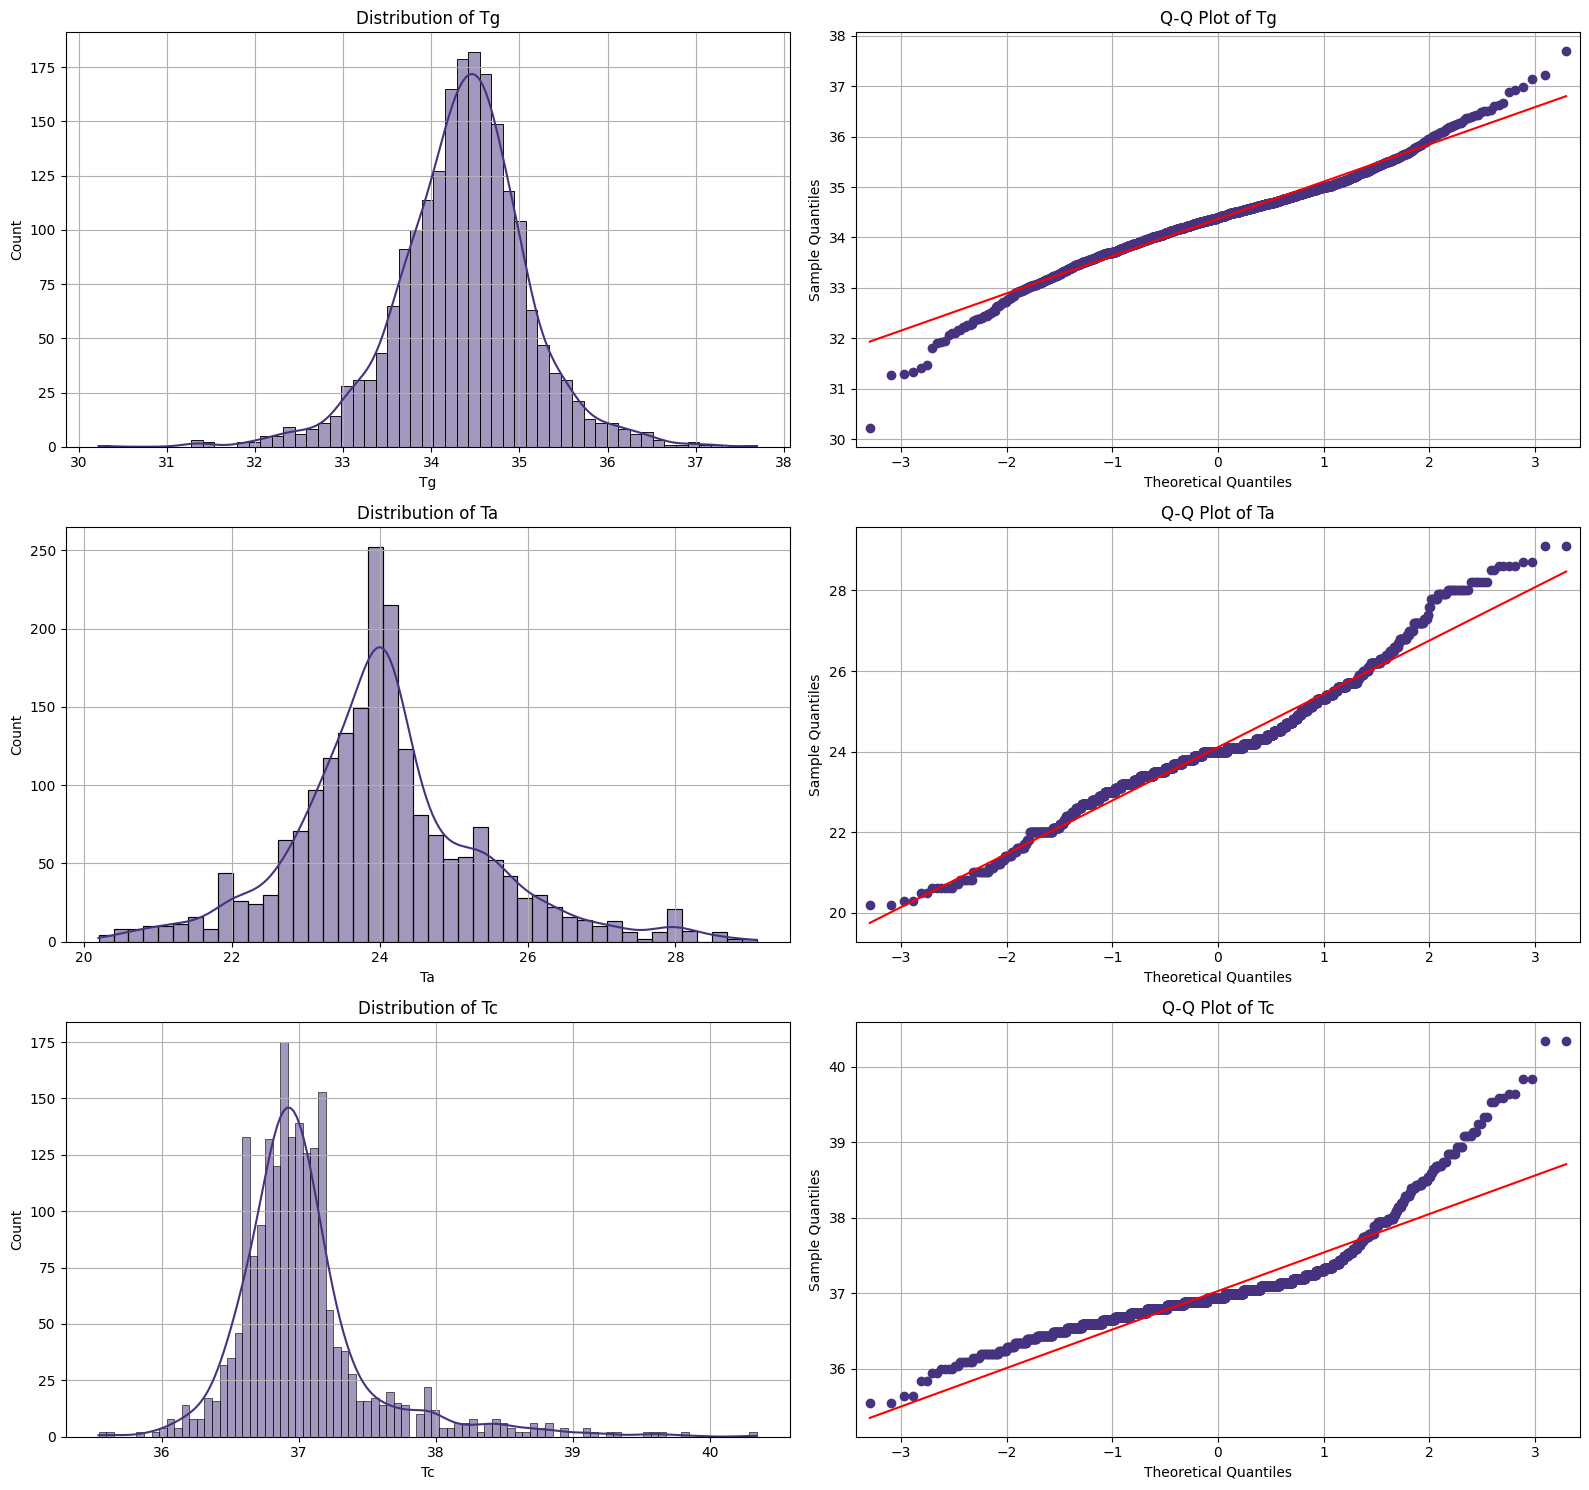

In [ ]:
from eda import distribution_analysis

distribution_analysis(external)

## Correlation Analysis



--- Correlation Analysis ---

Correlation Matrix:
       Tg     Ta     Tc
Tg  1.000  0.355  0.548
Ta  0.355  1.000  0.098
Tc  0.548  0.098  1.000

Pearson Correlation Coefficients:
Tg vs Tc: r = 0.5482, p-value = 1.6529e-159
  The correlation between Tg and Tc is statistically significant
Ta vs Tc: r = 0.0976, p-value = 1.0718e-05
  The correlation between Ta and Tc is statistically significant

Spearman Rank Correlation Coefficients:
Tg vs Tc: rho = 0.4274, p-value = 6.4331e-91
Ta vs Tc: rho = 0.1016, p-value = 4.5605e-06


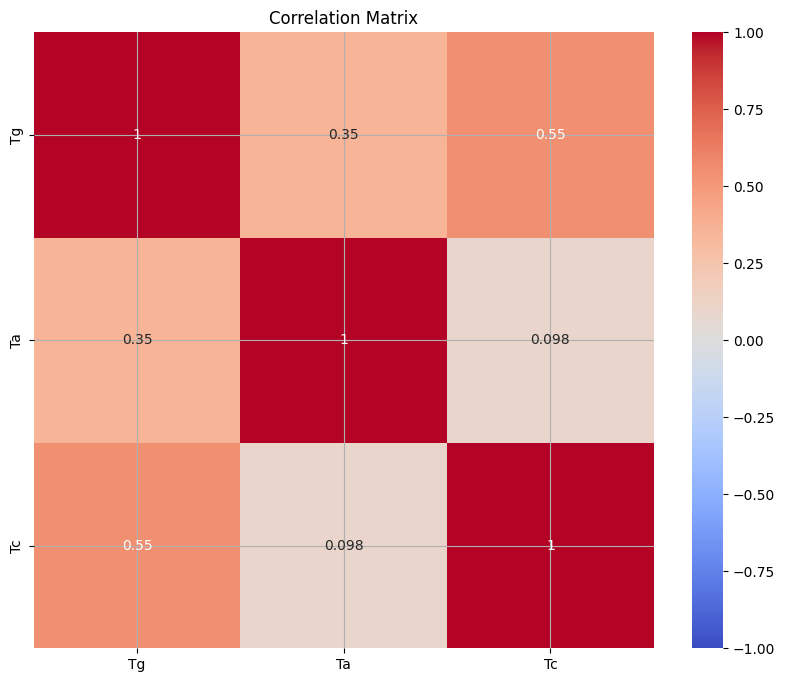

<Figure size 1500x1000 with 0 Axes>

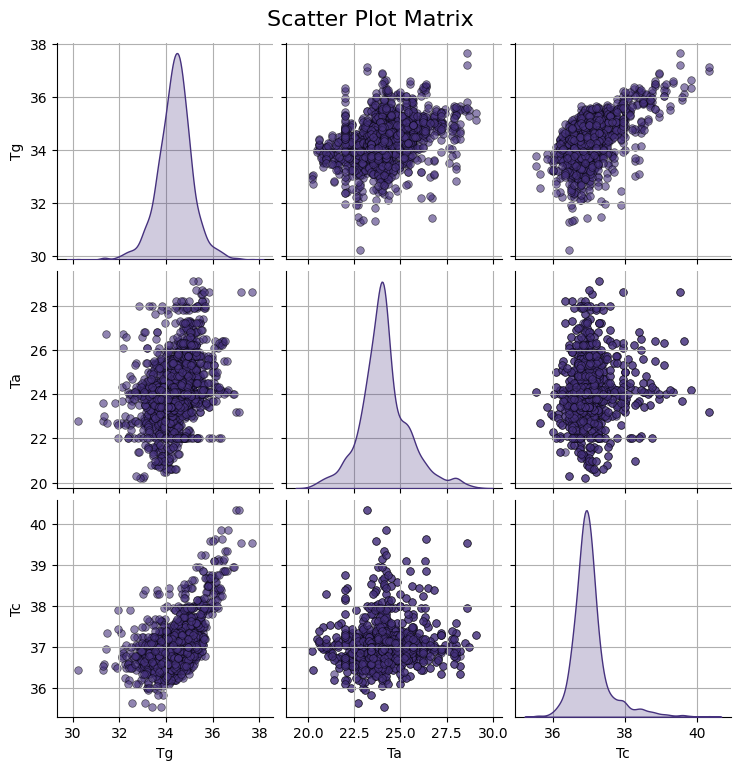

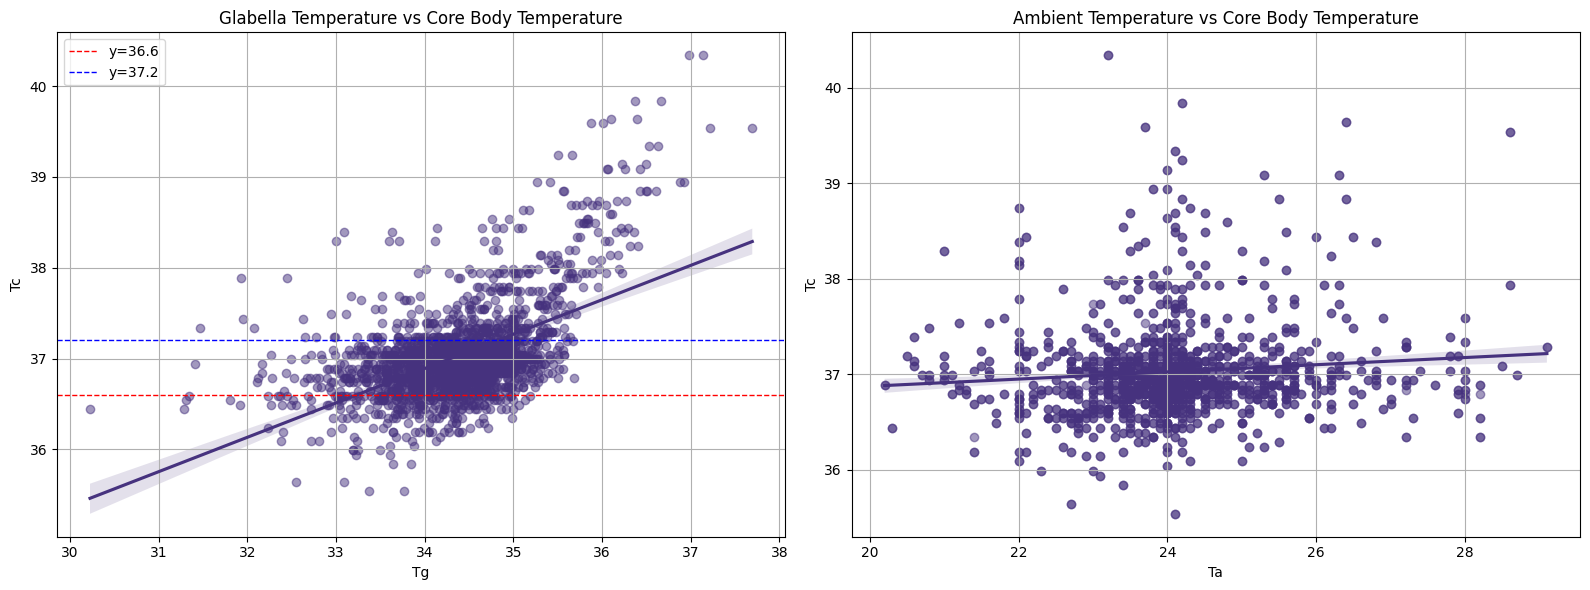

In [ ]:
from eda import correlation_analysis

correlation_analysis(external)